In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from moseq2_detectron_extract.io.proc import hampel_filter

from bottleneck import move_median

In [2]:
df = pd.read_csv('D:/moseq-extract-testing/session_20200814193726_top-score-vote-better-aug/keypoints.tsv', sep='\t')

In [3]:
df

,Frame_Idx,Flip,Centroid_X,Centroid_Y,Angle,Nose_X,Nose_Y,Nose_S,Left Ear_X,Left Ear_Y,...,rot_Left Hip_S,rot_Right Hip_X,rot_Right Hip_Y,rot_Right Hip_S,rot_TailBase_X,rot_TailBase_Y,rot_TailBase_S,rot_TailTip_X,rot_TailTip_Y,rot_TailTip_S
0,0,True,122.027981,221.122871,206.894641,146.251285,218.364580,0.455451,134.182275,216.670539,...,0.497696,114.567072,226.619593,0.591087,106.064462,223.116634,0.599728,78.949333,255.850441,0.543217
1,1,True,121.705445,220.825695,207.195759,145.507490,217.592085,0.516207,134.368286,215.532094,...,0.563364,114.439583,226.884164,0.662458,105.958734,223.458213,0.739685,79.970571,255.715192,0.684780
2,2,True,121.202948,220.520786,205.493161,146.592374,218.178758,0.522230,134.161683,215.303329,...,0.511488,112.535666,225.615241,0.554651,104.564286,222.814170,0.556651,78.445219,256.175014,0.680212
3,3,True,121.101996,220.509978,205.764581,146.416897,217.834888,0.526303,134.461354,215.938466,...,0.436319,111.646961,225.854724,0.509576,103.701867,223.117890,0.506549,79.612875,255.554595,0.634789
4,4,True,121.523449,220.858225,207.163149,148.291404,217.238769,0.551118,134.091026,215.639149,...,0.481845,113.360071,227.387336,0.610510,104.906386,223.949744,0.851318,81.273891,258.291190,0.550928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5995,True,200.973801,83.791213,-360.844311,223.261932,85.298530,0.316465,215.374311,81.189630,...,0.410581,192.410641,88.836524,0.430928,186.568463,80.765116,0.934363,151.059484,63.273034,0.708017
5996,5996,True,203.221943,83.969849,-363.491835,224.922099,84.335508,0.257238,217.124714,80.869613,...,0.421067,194.576066,89.460702,0.245559,188.079041,81.090660,0.452045,154.773477,69.091370,0.406755
5997,5997,True,205.102119,84.307803,-363.233443,223.686644,85.528966,0.303991,217.957841,81.266334,...,0.161552,197.512424,90.943503,0.226231,191.949987,83.736028,0.277638,172.280932,79.670598,0.186245
5998,5998,True,205.776950,84.965723,-367.402482,223.189107,85.800239,0.171004,217.665281,82.119488,...,0.119854,199.427491,91.602354,0.068985,191.331034,84.624275,0.073740,223.189107,85.800239,0.013314


In [4]:
keypoints = [
    'Nose',
    'Left Ear',
    'Right Ear',
    'Neck',
    'Left Hip',
    'Right Hip',
    'TailBase',
    'TailTip'
]
kp_markers = {
    'Nose': '>',
    'Left Ear': '^',
    'Right Ear': 'v',
    'Neck': '<',
    'Left Hip': '3',
    'Right Hip': '4',
    'TailBase': '8',
    'TailTip': 'P'
}
def plot_keypoints(d, keypoints=keypoints, kp_markers=kp_markers, ax=None):
    '''
    Parameters:
        d (pd.Series)
        keypoints (List[str])
        kp_markers (Dict[str, str])
    '''
    sigs = [d['rot_{}_S'.format(kp)] for kp in keypoints]
    vmin = min(sigs)
    vmax = max(sigs)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.scatter(d['Centroid_X'], d['Centroid_Y'], label='Centroid', marker='*')
    for kp in keypoints:
        im = ax.scatter(d['rot_{}_X'.format(kp)], d['rot_{}_Y'.format(kp)], c=d['rot_{}_S'.format(kp)], vmin=vmin, vmax=vmax, marker=kp_markers[kp], label=kp)
    ax.legend()
    ax.invert_yaxis()
    plt.gcf().colorbar(im, ax=ax, label='Confidence')

    
    
def calc_keypoint_dist(d, keypoints=keypoints):
    keys = ['rot_{}'.format(kp) for kp in keypoints] + ['Centroid']
    dist = np.ndarray((len(keys), len(keys)), dtype=float)
    for i, kp1 in enumerate(keys):
        for j, kp2 in enumerate(keys):
            x1 = d['{}_X'.format(kp1)]
            y1 = d['{}_Y'.format(kp1)]
            x2 = d['{}_X'.format(kp2)]
            y2 = d['{}_Y'.format(kp2)]
            dist[i, j] = math.sqrt( ((x1-x2)**2) + ((y1-y2)**2) )
    return dist


def keypoint_dist_mat(d, keypoints=keypoints, ax=None):
    dist = calc_keypoint_dist(d, keypoints=keypoints)
    labels = keypoints + ['Centroid']      
    sns.heatmap(dist, xticklabels=labels, yticklabels=labels, ax=ax, cbar_kws={'label': 'Distance between Keypoints'})



def plot_kp_info(d):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot_keypoints(d, ax=ax[0])
    keypoint_dist_mat(d, ax=ax[1])
    fig.tight_layout()
    
    
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def filter_angles(data):
    out = np.array(data.shape, dtype=data.dtype)
    for i, win in enumerate(rolling_window(data, 10)):
        med = np.median(win)
        print(win)
        
def filter_angles2(data):
    out = np.copy(data)
    diff = np.diff(data, prepend=data[0])
    absdiff = np.abs(diff)
    flips = ((absdiff>120) & (absdiff<240))
    signs = np.sign(diff[flips])
    out[flips] = out[flips] + (-180 * signs)
    return out

def iterative_filter_angles(data):
    last = np.copy(data)
    while True:
        curr = filter_angles2(last)
        
        if np.allclose(curr, last):
            return curr
        else:
            last = curr

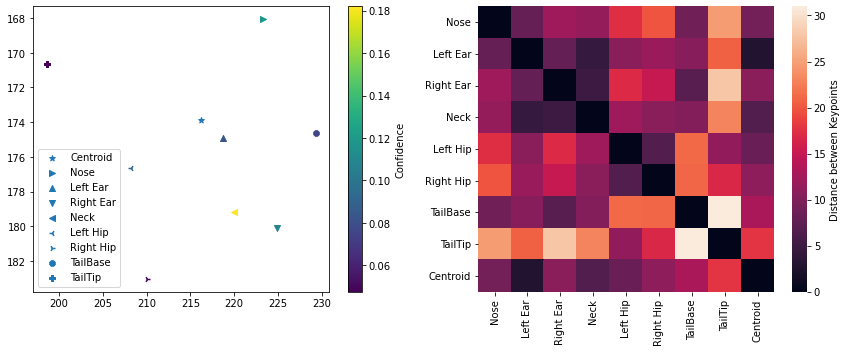

In [5]:
plot_kp_info(df.loc[1309])

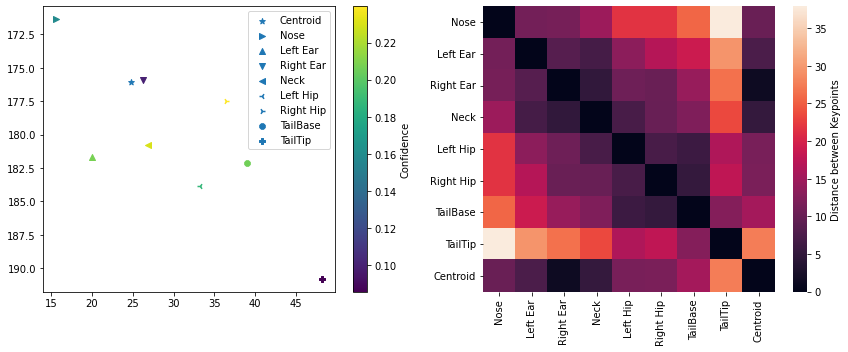

In [27]:
plot_kp_info(df.loc[5105])

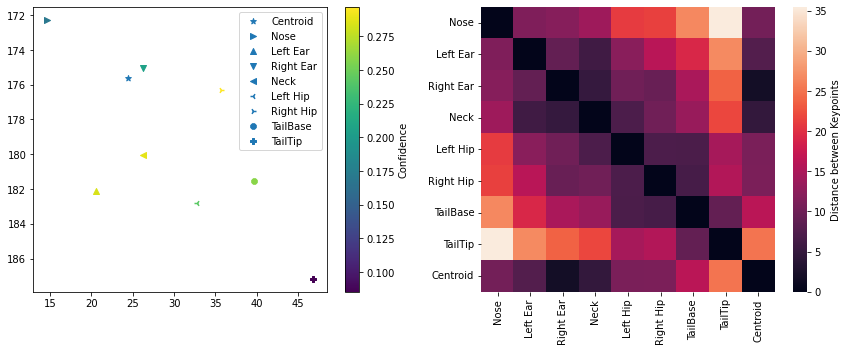

In [28]:
plot_kp_info(df.loc[5106])

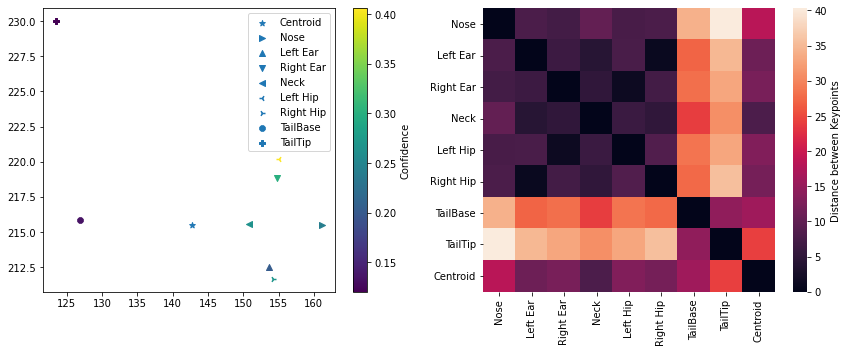

In [18]:
plot_kp_info(df.loc[103])

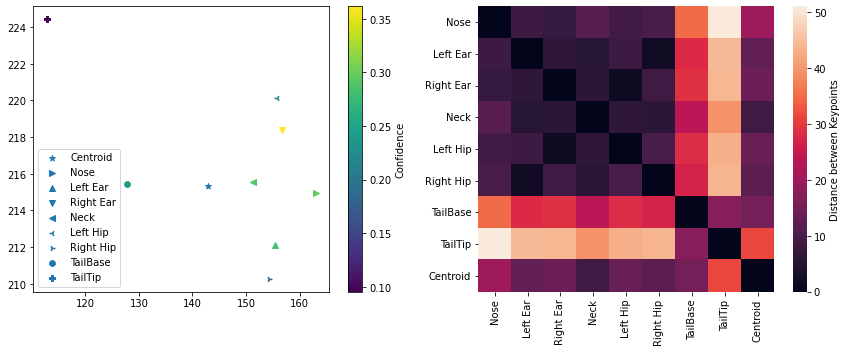

In [19]:
plot_kp_info(df.loc[104])

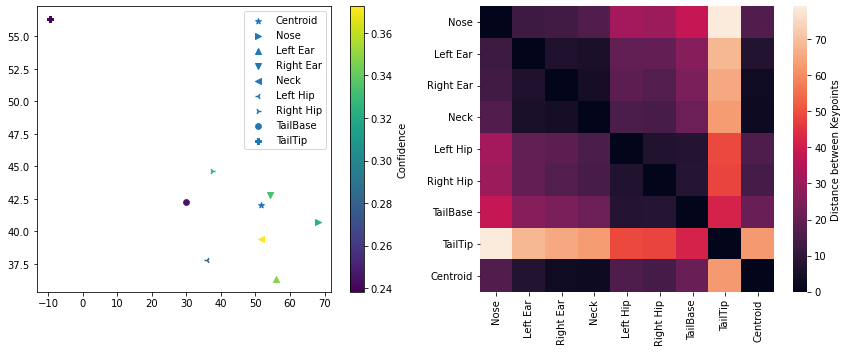

In [20]:
plot_kp_info(df.loc[1097])

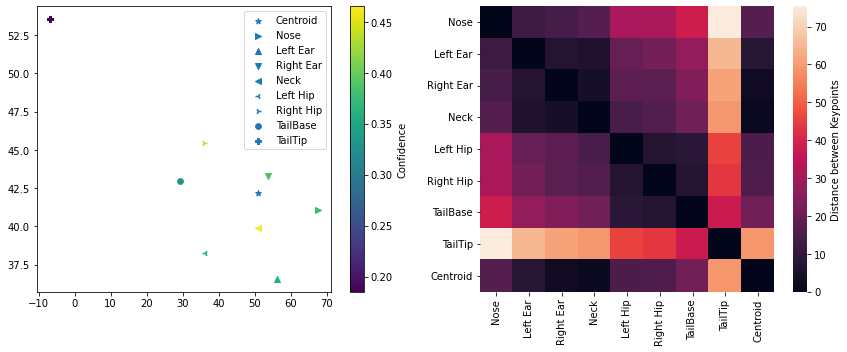

In [21]:
plot_kp_info(df.loc[1098])

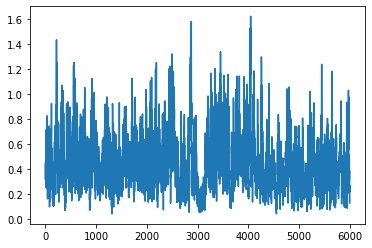

In [12]:
plt.plot(df['Nose_S'])

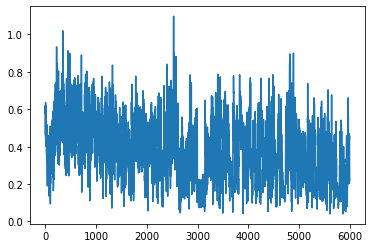

In [13]:
plt.plot(df['Left Ear_S'])

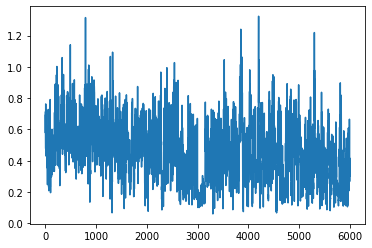

In [14]:
plt.plot(df['Neck_S'])

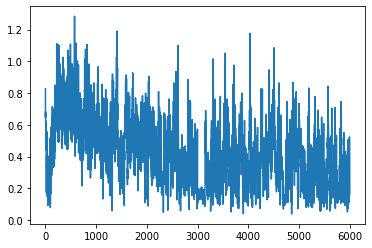

In [15]:
plt.plot(df['Left Hip_S'])

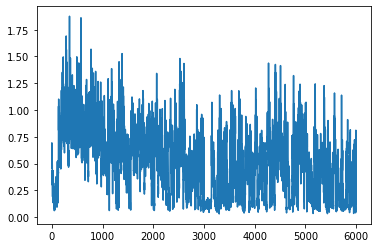

In [16]:
plt.plot(df['TailBase_S'])

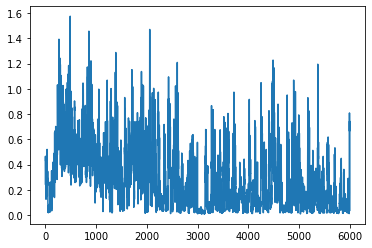

In [17]:
plt.plot(df['TailTip_S'])

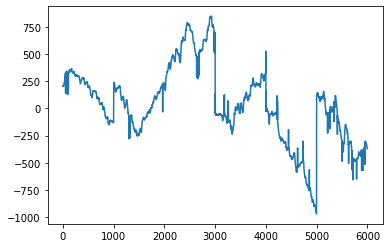

In [24]:
plt.plot(df['Angle'])

Converged after 1001 iterations


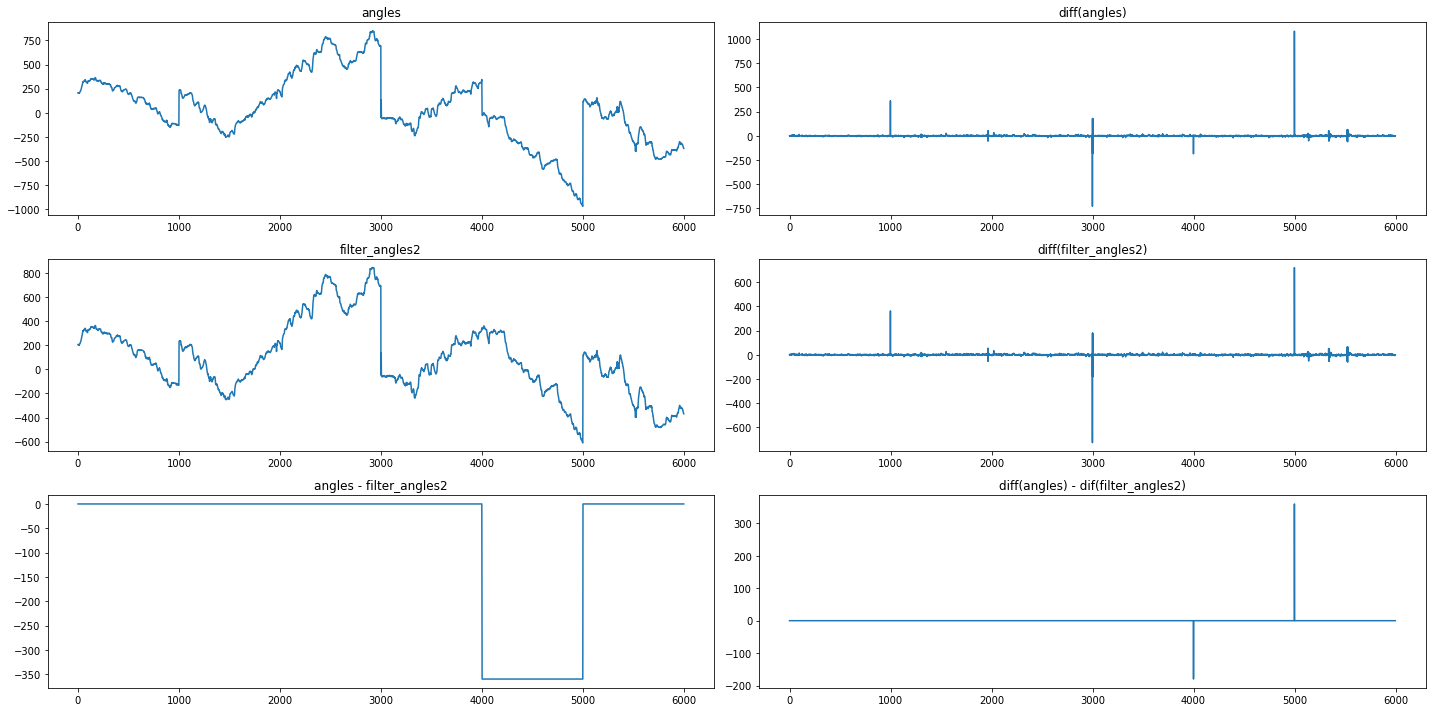

In [5]:


def filter_angles3(angles, window=3):
    out = np.copy(angles)
    windows = move_median(angles, window=window, min_count=1)
    diff = out - windows
    absdiff = np.abs(diff)
    flips = ((absdiff>120) & (absdiff<240))
    signs = np.sign(diff[flips])
    out[flips] = out[flips] + (-180 * signs)
    #print(np.count_nonzero(flips))
    return out
        
def iterative_filter_angles3(data):
    last = np.copy(data)
    iterations = 0
    while True:
        iterations += 1
        curr = filter_angles3(last)
        
        if np.allclose(curr, last):
            print(f'Converged after {iterations} iterations')
            return curr
        else:
            last = curr

span = 7
sigma = 3

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
#filtered = hampel_filter(np.copy(df['Angle'].values), span, sigma)
angles = df['Angle'].values

filtered = iterative_filter_angles3(angles)
flips = df['Flip'].values

ax[0,0].set_title('angles')
ax[0,0].plot(angles)

ax[1,0].set_title('filter_angles2')
ax[1,0].plot(filtered)


ax[0,1].set_title('diff(angles)')
ax[0,1].plot(np.diff(angles))

ax[1,1].set_title('diff(filter_angles2)')
ax[1,1].plot(np.diff(filtered))

ax[2,1].set_title('diff(angles) - dif(filter_angles2)')
ax[2,1].plot(np.diff(angles) - np.diff(filtered))

ax[2,0].set_title('angles - filter_angles2')
ax[2,0].plot(angles - filtered)

#ax[1,1].set_title('flips')
#ax[1,1].plot(flips)

fig.tight_layout()

In [48]:
angles - move_median(angles, window=3, min_count=1)

array([ 0.        ,  0.15055877, -1.40148031, ...,  0.        ,
       -3.91064743, -1.63687618])

In [31]:

        
filter_angles2(df['Angle'].values)

array([ 204.70618612,  204.60464662,  205.4403018 , ..., -361.97417133,
       -366.08535054, -367.90509722])

In [77]:
iterative_filter_angles(df['Angle'].values)

[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False

array([ 204.70618612,  204.60464662,  205.4403018 , ..., -361.97417133,
       -366.08535054, -367.90509722])

In [31]:
print(np.mean(df['Angle'].diff()))
print(np.median(df['Angle'].diff()))
#np.mode(df['Angle'].diff())

-0.09545112241075274
nan


In [33]:
df['Angle'].diff()

0            NaN
1      -0.101540
2       0.835655
3       0.103328
4       0.370124
          ...   
5995   -0.739894
5996   -2.448000
5997    1.136753
5998   -4.111179
5999   -1.819747
Name: Angle, Length: 6000, dtype: float64

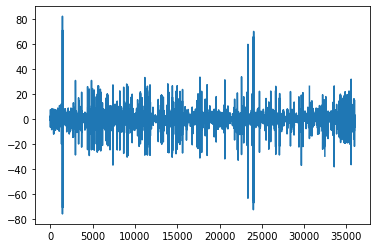

In [9]:
plt.plot(np.diff(df['Nose_X']))

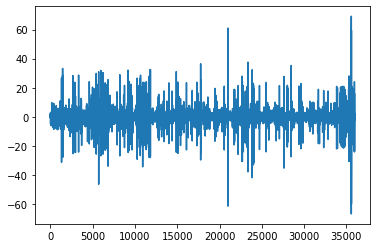

In [10]:
plt.plot(np.diff(df['Nose_Y']))

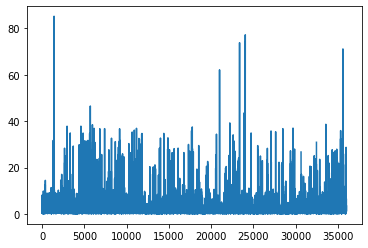

In [12]:
plt.plot(np.sqrt((np.diff(df['Nose_X']) ** 2) + (np.diff(df['Nose_Y']) ** 2)))

In [14]:
dists = []
for i, d in df.iterrows():
    dists.append(calc_keypoint_dist(d))
dists = np.array(dists)
dists

array([[[ 0.        ,  8.58384486,  8.01898073, ..., 36.08271081,
         72.71254049, 21.63733627],
        [ 8.58384486,  0.        ,  8.53475079, ..., 28.97284455,
         68.51766509, 14.38882527],
        [ 8.01898073,  8.53475079,  0.        , ..., 29.5630102 ,
         64.71560184, 15.87666924],
        ...,
        [36.08271081, 28.97284455, 29.5630102 , ...,  0.        ,
         44.08269563, 14.60249244],
        [72.71254049, 68.51766509, 64.71560184, ..., 44.08269563,
          0.        , 55.58149649],
        [21.63733627, 14.38882527, 15.87666924, ..., 14.60249244,
         55.58149649,  0.        ]],

       [[ 0.        ,  9.93205551,  8.93258667, ..., 37.80008677,
         71.57117478, 22.42161492],
        [ 9.93205551,  0.        ,  8.48815276, ..., 29.61121582,
         66.58195441, 13.87037968],
        [ 8.93258667,  8.48815276,  0.        , ..., 29.799998  ,
         62.65433483, 15.33122774],
        ...,
        [37.80008677, 29.61121582, 29.799998  , ...,  

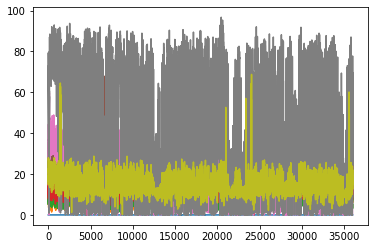

In [17]:
plt.plot(dists[:,0])